# Download data from Meteo France - Mountain weather stations

2010-2020

In [111]:
from urllib.request import Request, urlopen
import gzip
import pandas as pd
from plotly import express as px, graph_objects as go
from datetime import datetime, time

In [26]:
def get_url_monthly(year: int, month: int):
    return f'https://donneespubliques.meteofrance.fr/donnees_libres/Txt/Nivo/Archive/nivo.{year}{month:02}.csv.gz'

In [153]:
for year in range(2010, 2021):
    for month in range (1, 13):
        req = Request(get_url_monthly(year, month))
        req.add_header('Accept-Encoding', 'gzip')
        response = urlopen(req)
        content = gzip.decompress(response.read())
        decomp_req = content.splitlines()
        with open(f'data/MeteoFrance/{year}-{month:02}.csv', 'w') as f:
            f.writelines([line.decode('utf-8').replace('mq', '') + '\n' for line in decomp_req])

In [187]:
df_reads = []
for year in range(2011, 2020):
    for month in range(1, 13):
        df_reads.append(pd.read_csv(f'data/MeteoFrance/{year}-{month:02}.csv', sep=';'))
df = pd.concat(df_reads)

In [189]:
df['date'] = pd.to_datetime(df.date.astype(str).apply(lambda d: f'{d[0:4]}-{d[4:6]}-{d[6:8]}T{d[8:14]}' if not pd.isna(d) else None))
df['t_C'] = df.t - 272.15

In [170]:
df.head(4)

,numer_sta,date,haut_sta,dd,ff,t,td,u,ww,w1,...,neige_fraiche,teneur_eau,grain_predom,grain_nombre,grain_diametr,homogeneite,m_vol_neige,Unnamed: 48,Unnamed: 49,t_C
0,7970,2011-01-01 07:45:00,1789.0,0.0,0.0,275.15,272.06,80.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
1,7872,2011-01-01 07:30:00,1355.0,0.0,0.0,271.95,271.25,95.0,0.0,0.0,...,NaN,NaN,6.0,6.0,NaN,2.0,NaN,NaN,NaN,-0.2
2,7920,2011-01-01 08:00:00,1720.0,0.0,0.0,269.15,264.85,72.0,0.0,0.0,...,0.0,NaN,7.0,8.0,NaN,2.0,NaN,NaN,NaN,-3.0
3,7962,2011-01-01 08:00:00,680.0,0.0,0.0,274.55,273.24,91.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4


In [190]:
df[~df.t.isna()].groupby('numer_sta').t.count().reset_index().sort_values('t', ascending=False)

,numer_sta,t
23,7590,5273
106,7931,4677
30,7608,4655
4,7457,4397
74,7893,3841
...,...,...
118,7948,4
117,7946,4
155,7994,4
21,7585,3


In [191]:
stations = [7457, 7470, 7567, 7811, 7815, 7856, 7893, 7907, 7922]
station_names= ['Vacheresse', 'La Flégère', 'Val Cenis', 'Alpe d\'Huez 2350', 'Orelle', 'Flaine', 'Courchevel', 'Le Corbier', 'Valloire']
station_labels = {s: sn for s, sn in zip(stations, station_names)}
# KO: 7897: 'Les Contamines', 7911: 'Les Saisies'

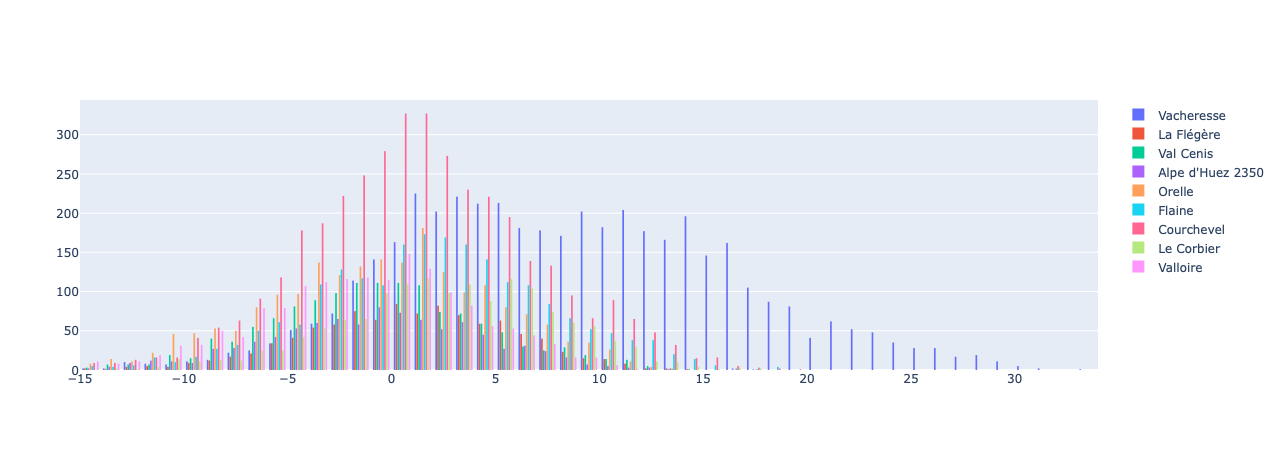

In [192]:
fig = go.Figure(layout=dict(bargroupgap=0.1))
for s, sn in zip(stations, station_names):
    fig.add_histogram(x = df[df.numer_sta == s].t_C, name=sn, xbins={'start': -15, 'end': 40, 'size': 1})
fig

In [194]:
df.set_index('date', inplace=True)
#df.reset_index()

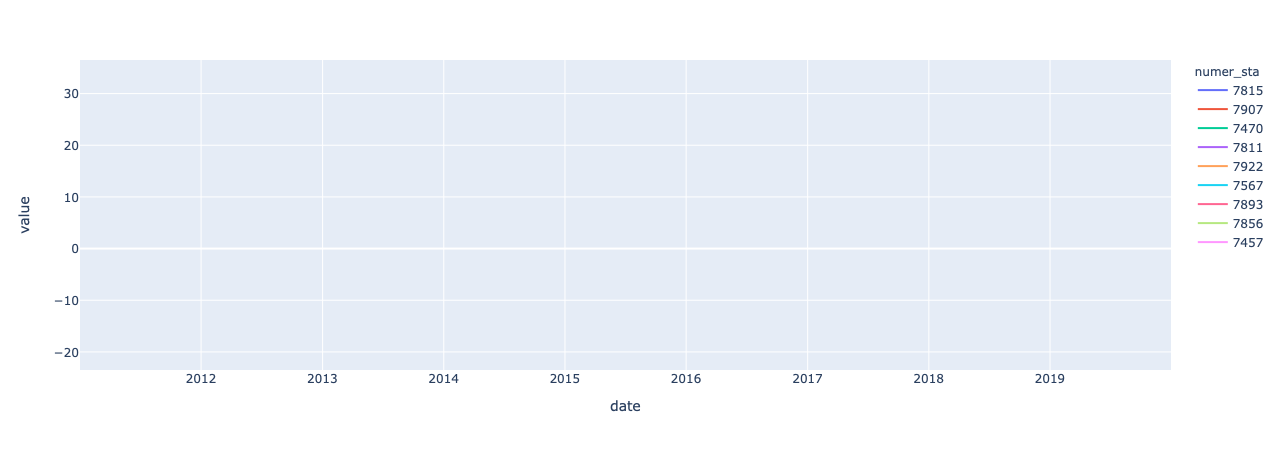

In [195]:
px.line(df[df.numer_sta.isin(stations) & (df.index.time >= time(8, 0)) & (df.index.time < time(10, 0))][['t_C', 'numer_sta']], color='numer_sta')

In [112]:
df.index.time < time(9, 0)

array([ True,  True,  True, ..., False, False, False])

## Conclusion

There is no weather station that provides temperature over the full skiing season: from november to june.